In [1]:
# Import libraries
from cil.framework import  AcquisitionGeometry
from cil.optimisation.functions import L2NormSquared, TotalVariation, BlockFunction, TotalVariation, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import BlockOperator, MatrixOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cil.plugins.astra.utilities import convert_geometry_to_astra
from cil.optimisation.functions import ZeroFunction, IndicatorBox
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.plugins import TomoPhantom

import matplotlib.pyplot as plt

from cvxpy import *
import astra

import numpy as np

In [2]:
# Detectors
N = 128
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, 0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


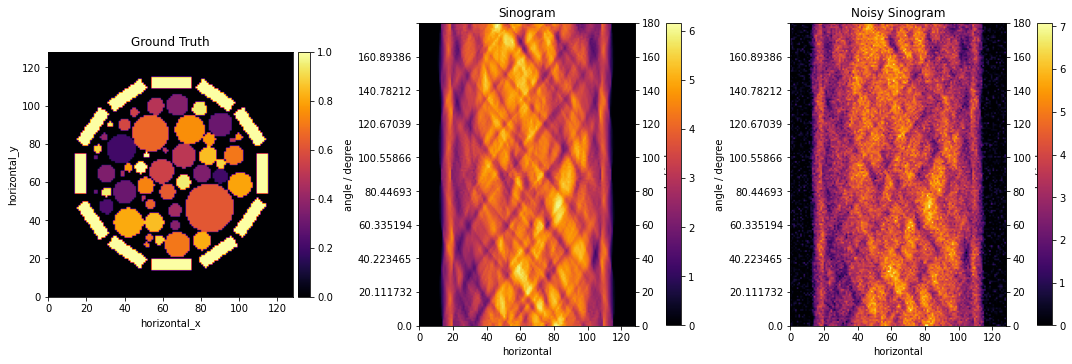

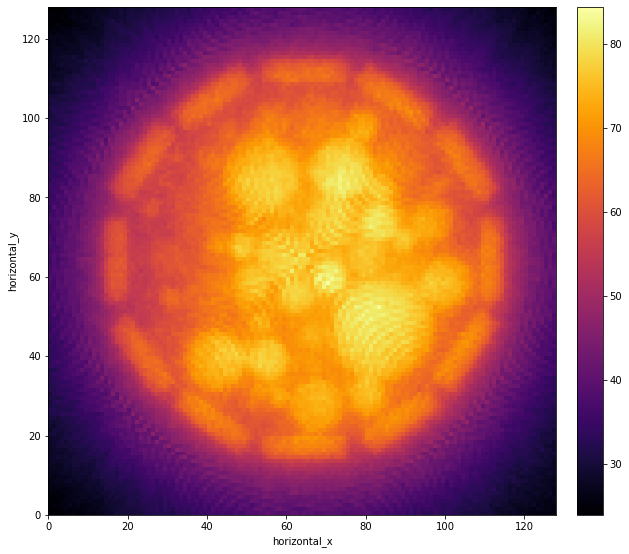

In [3]:
# Get phantom
# phantom = dataexample.SIMPLE_PHANTOM_2D.get(size=(N, N))
phantom = TomoPhantom.get_ImageData(12, ig)

# Create an acqusition data
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

np.random.seed(10)

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], 
       title = ['Ground Truth','Sinogram','Noisy Sinogram'], 
       num_cols=3, cmap = 'inferno')

show2D(A.adjoint(noisy_sino), cmap="inferno")

In [4]:
alpha = 1.5

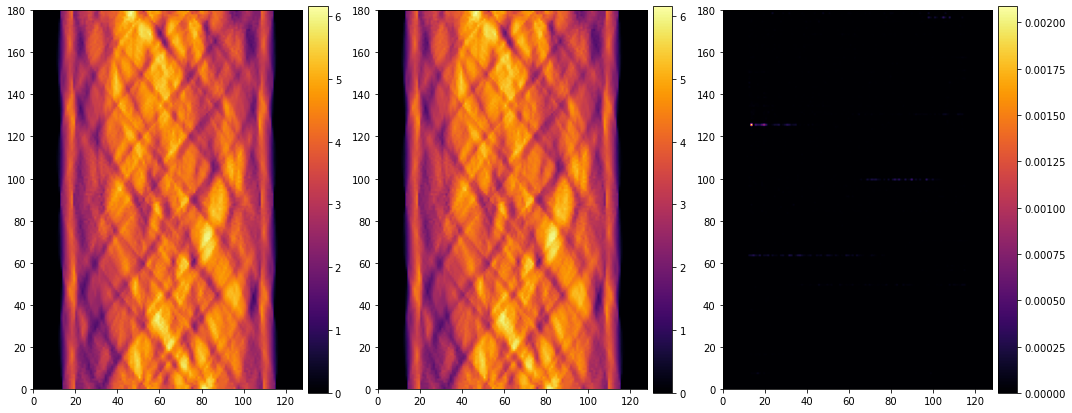

In [5]:
# convert to astra geometries
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

# projection id
proj_id = astra.create_projector('line', ag_astra, ig_astra)

# matrix id
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)

sino_astra = (W*phantom.array.flatten()).reshape((len(ag.angles), N))

#show
show2D([sino_astra, sino.array, np.abs(sino.array-sino_astra)], num_cols=3, cmap="inferno")

# print("Norm of A_cil = {}".format(A.norm()))

# mat_cil = MatrixOperator(W.T*W)

# print("Norm of astra mat = {}".format(np.sqrt(mat_cil.norm())))



In [6]:
N, M = ig.shape
u_cvx = Variable(N*M)
fidelity = sum_squares(W@u_cvx.flatten() - noisy_sino.array.flatten())
constraints = [u_cvx>=0]

regulariser = (alpha/ig.voxel_size_x) * tv(reshape(u_cvx, (N,M))) 
obj =  Minimize( fidelity + regulariser)
prob = Problem(obj, constraints)

res = prob.solve(solver = MOSEK, verbose = True)
# res = prob.solve(solver = SCS, verbose = True, eps=1e-3)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) May 04 07:52:47 PM: Your problem has 16384 variables, 1 constraints, and 0 parameters.
(CVXPY) May 04 07:52:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 07:52:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 07:52:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 07:52:47 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 04 07:52:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

In [17]:
K = A
F = L2NormSquared(b=noisy_sino)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

recons = {}

max_iteration = [1,2,5,10]

for i in max_iteration:
    G = alpha*TotalVariation(max_iteration=i, tolerance=0, warmstart=True)

    # Setup and run PDHG
    pdhg_implicit_fgp_tv_warm = PDHG(f = F, g = G, operator = K, 
                max_iteration = 300, sigma=sigma, tau=tau,
                update_objective_interval = 1)
    pdhg_implicit_fgp_tv_warm.run(verbose=0)
    recons[i] = pdhg_implicit_fgp_tv_warm
    
    

PDHG setting up
PDHG configured
Initialised GradientOperator with C backend running with  20  threads


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:435: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")


PDHG setting up
PDHG configured
Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
Initialised GradientOperator with C backend running with  20  threads


In [18]:
G1 = alpha*TotalVariation(max_iteration=50,tolerance=0, warmstart=False)

# Setup and run PDHG
pdhg_implicit_fgp_tv_nowarm = PDHG(f = F, g = G1, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_fgp_tv_nowarm.run(verbose=0)

PDHG setting up
PDHG configured
Initialised GradientOperator with C backend running with  20  threads


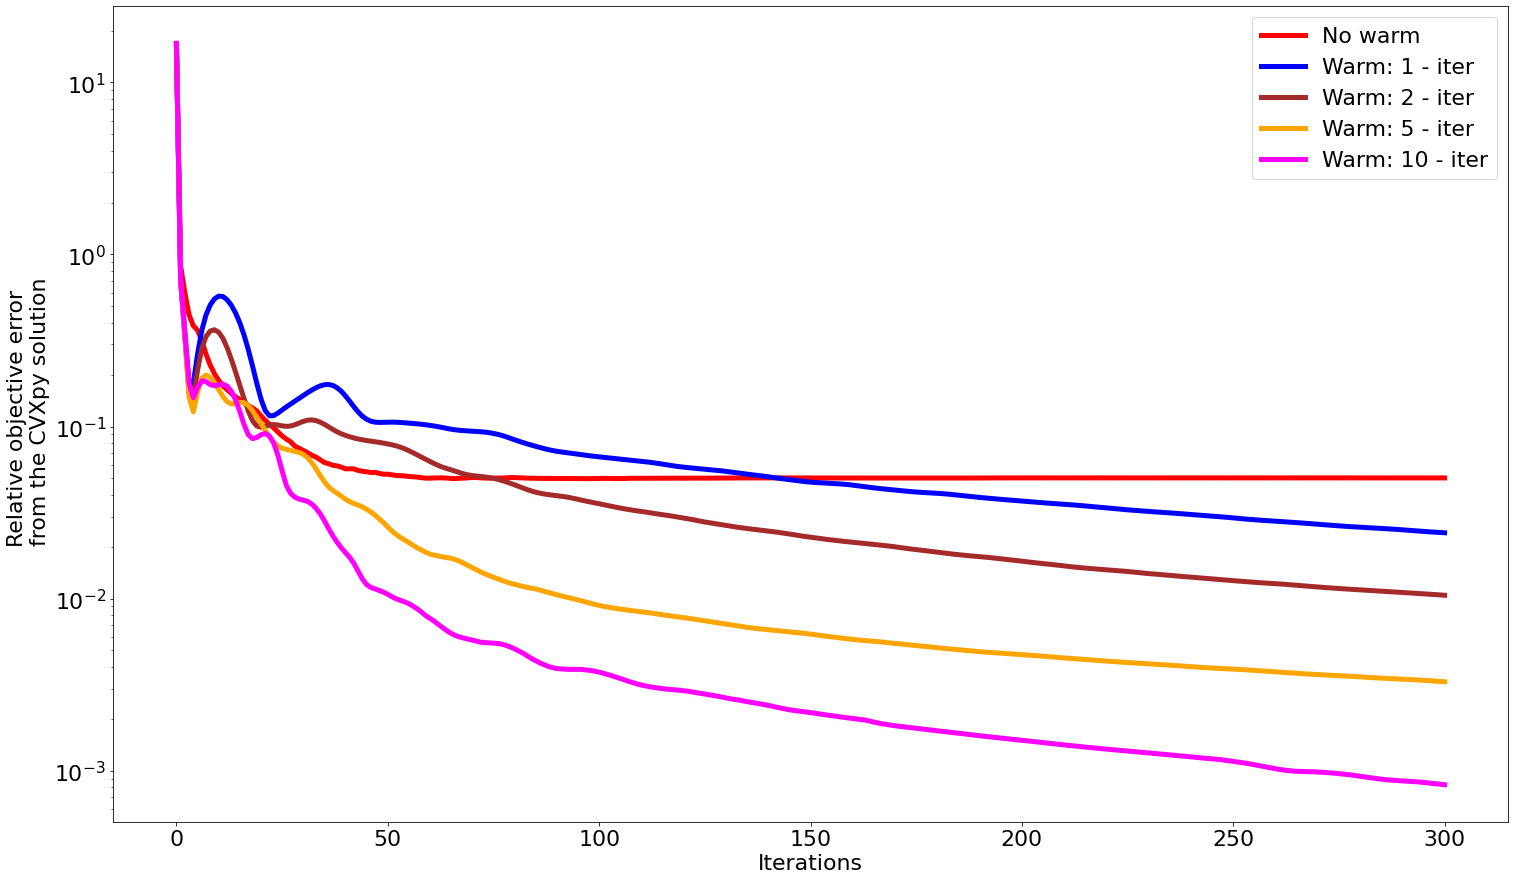

In [21]:
plt.rcParams.update({'font.size': 22, 'lines.linewidth': 5.})
plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_implicit_fgp_tv_nowarm.objective - obj.value)/obj.value, label = "No warm", color="red")
plt.semilogy( np.abs(recons[1].objective - obj.value)/obj.value, label = "Warm: 1 - iter", color="blue")
plt.semilogy( np.abs(recons[2].objective - obj.value)/obj.value, label = "Warm: 2 - iter", color="brown")
plt.semilogy( np.abs(recons[5].objective - obj.value)/obj.value, label = "Warm: 5 - iter", color="orange")
plt.semilogy( np.abs(recons[10].objective - obj.value)/obj.value, label = "Warm: 10 - iter", color="magenta")
plt.legend()
plt.ylabel("Relative objective error \n from the CVXpy solution")
plt.xlabel("Iterations")
plt.show()



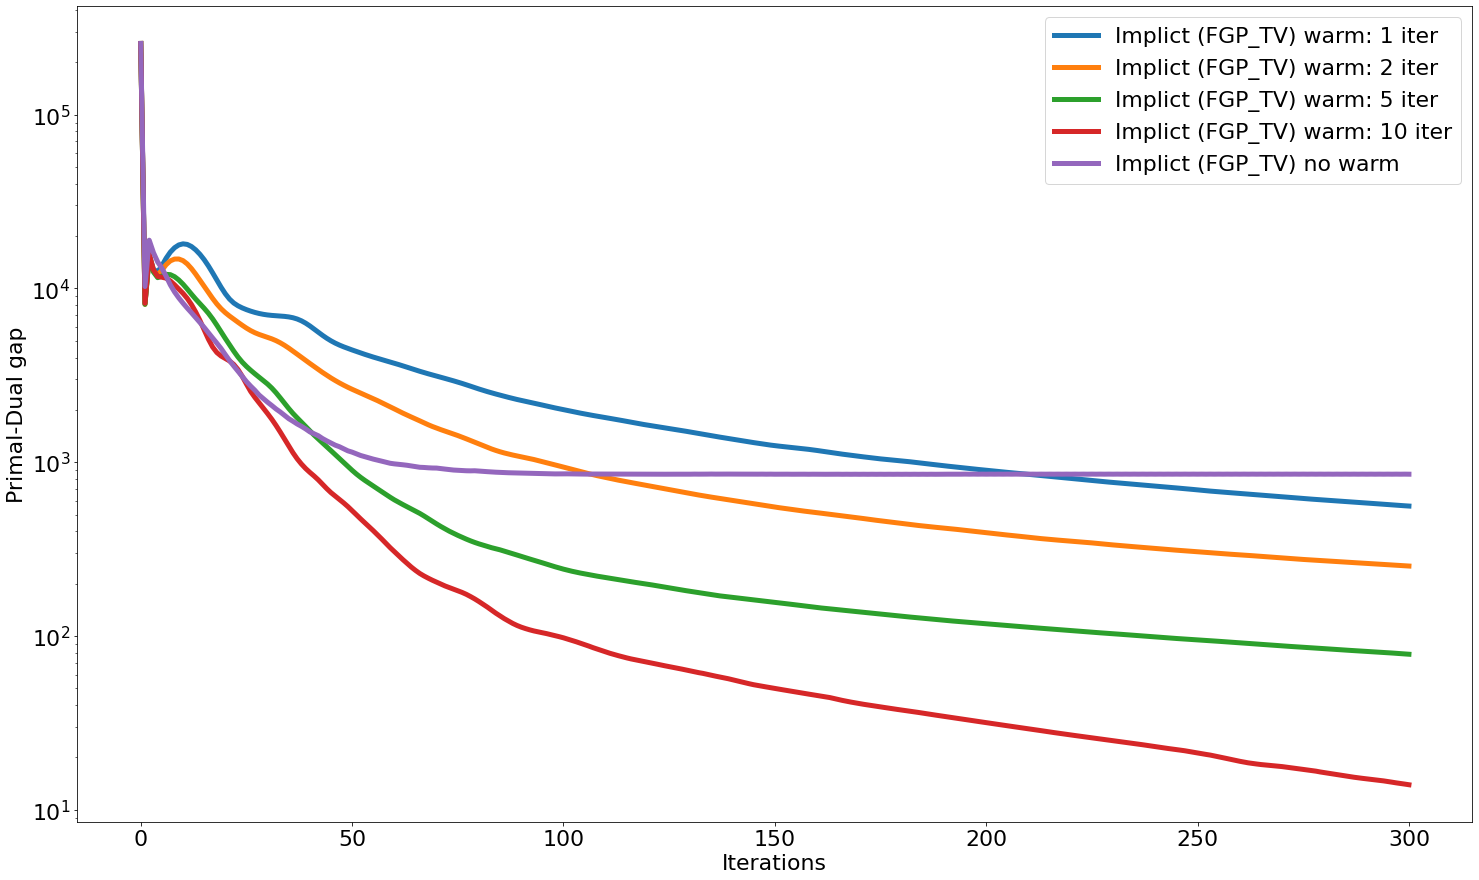

In [22]:
plt.figure(figsize=(25,15))
plt.semilogy( recons[1].primal_dual_gap, label = "Implict (FGP_TV) warm: 1 iter")
plt.semilogy( recons[2].primal_dual_gap, label = "Implict (FGP_TV) warm: 2 iter")
plt.semilogy( recons[5].primal_dual_gap, label = "Implict (FGP_TV) warm: 5 iter")
plt.semilogy( recons[10].primal_dual_gap, label = "Implict (FGP_TV) warm: 10 iter")
plt.semilogy( pdhg_implicit_fgp_tv_nowarm.primal_dual_gap, label = "Implict (FGP_TV) no warm")
plt.legend()
plt.ylabel("Primal-Dual gap")
plt.xlabel("Iterations")
plt.show()


In [23]:
u_cvx_sol = u_cvx.value.reshape(ig.shape)

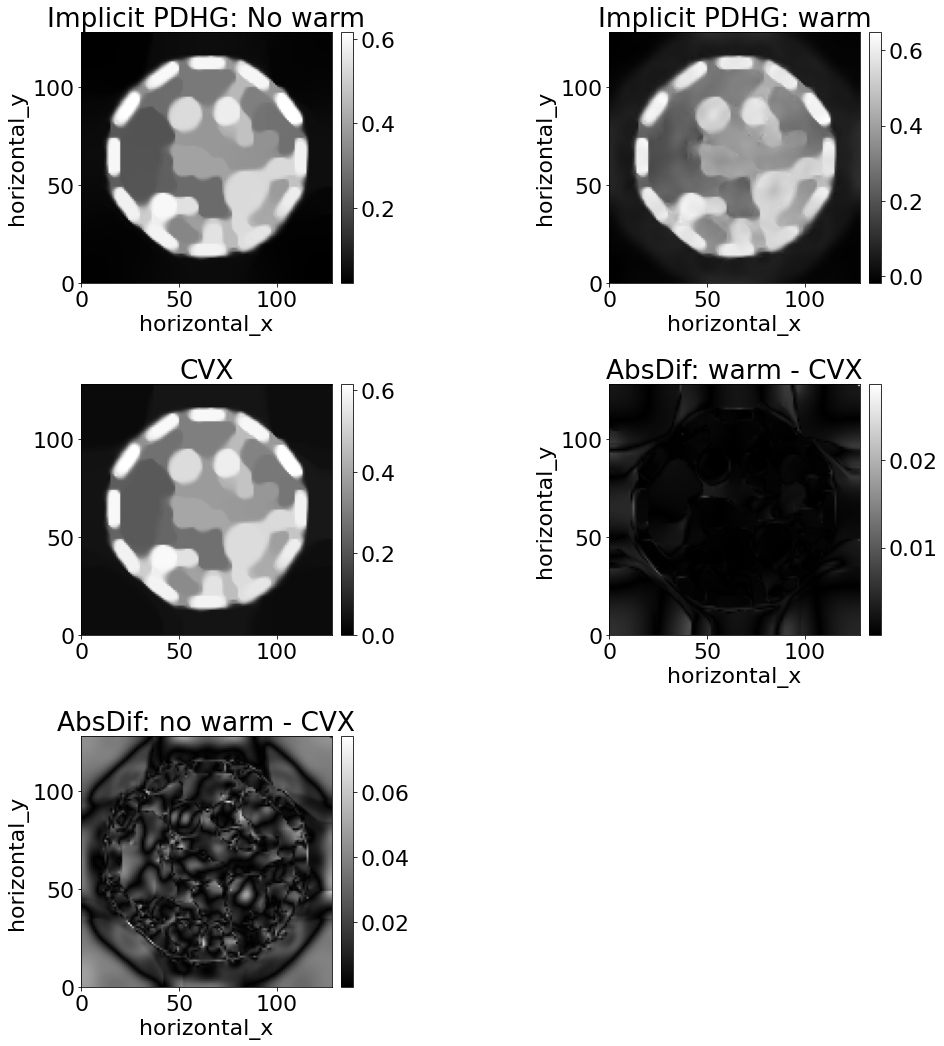

In [24]:
show2D([recons[10].solution, 
        pdhg_implicit_fgp_tv_nowarm.solution,
        u_cvx_sol,
       (pdhg_implicit_fgp_tv_warm.solution - u_cvx_sol).abs(),
       (pdhg_implicit_fgp_tv_nowarm.solution - u_cvx_sol).abs()], 
       title=['Implicit PDHG: No warm', 'Implicit PDHG: warm', 'CVX',
             'AbsDif: warm - CVX','AbsDif: no warm - CVX' ])